## Loading data

In [1]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
import seaborn as sns
from scipy import stats
from tabulate import tabulate
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')
%load_ext autoreload
%autoreload 2

/Users/jonathanma/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [2]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>


#### Crop activity data to get rid of activity #3

In [3]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

Functions from the notebook ""

In [4]:
def add_text(attribute,family_category,cut_off, shortest_seq_length, longest_seq_length,B):
    text = """Showing sequences for students split by {0}, using the categories {1}.
            Removed sequences used by less than {2}% of students.
            Found sequences of lenght {3} to {4}.
            Using {5} time bins""".format(attribute,family_category,int(cut_off*100), shortest_seq_length, longest_seq_length,B)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.text(0.5,0.5,text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize = 15)
    plt.axis('off')
    return fig

def rank_sequences(sequence_counts,B,axesnum=None,ignore_first_time_bin=False):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
#         if np.sum(counts)>0:
        ranks.append((seq,calc_infogain(counts,B,axesnum,ignore_first_time_bin)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

## Preparing our groups
So we want to take a look at what the high prior knowledge are doing. Remember that we have 25 such students, 22 HH and 3 HL.

In [5]:
median_learning0 = 0.45
df_scores['split pre'] = df_scores.apply (lambda row: label_learning (median_learning0,row,"z pre"),axis=1)
median_learning2 = np.median(df_scores[df_scores['split pre']=='low']['z post t2'])
df_scores['split post t2'] = df_scores.apply (lambda row: label_learning (median_learning2,row,"z post t2"),axis=1)

In [6]:
for x in ['high','low']:
    for y in ['high','low']:
        print x,y, len(set(df_scores[(df_scores['split pre']==x)&(df_scores['split post t2']==y)]['student']))

high high 22
high low 3
low high 38
low low 36


We want to compare the three groups to each other. We would like to know if:
- HH look like LL in which case LL use experts strategies that are productive with certain level of prior knowledge
- HH look like LH in which case they used productive strategies

We need to make a new funciton to run the sequence mining with 3 groups.

### Let's make those three groups

In [7]:
def label_3_groups (row):
    if row['split pre']  == 'high' and row['split post t2'] == 'high':
        return 'HH'
    if row['split pre']  == 'high' and row['split post t2'] == 'low':
        return 'HL'
    if row['split pre']  == 'low' and row['split post t2'] == 'high':
        return 'LH'
    if row['split pre']  == 'low' and row['split post t2'] == 'low':
        return 'LL'
df_scores['three groups'] = df_scores.apply (lambda row: label_3_groups (row),axis=1)

## Let's run the sequence mining like we usually do on all 3 groups

In [8]:
# students = list(set(get_students()) - set(df_scores[df_scores['three groups']=='HL']['student']))
students = list(set(df_scores['student']) - set(df_scores[df_scores['three groups']=='HL']['student']))
CUT_OFF = 0.40 #we keep only sequences used once by at least 10% of students
shortest_seq_length = 1
longest_seq_length = 10

### PARAMETERS
attribute = 'three groups'
level1 = 'LH'
level2 = 'LL'
level3 = 'HH'
family_category = "Family"
group_sizes = np.array([len(set(df_scores[df_scores['three groups']==level1]['student'])),len(set(df_scores[df_scores['three groups']==level2]['student'])),len(set(df_scores[df_scores['three groups']==level3]['student']))])

BINS = 1
axis = 1
sequence_counts_group = get_sequence_use_by_timebin(df,students,family_category,
                                          BINS,attribute,level1,level2,
                                          shortest_seq_length,longest_seq_length,CUT_OFF,level3='HH',ignore=['I'])
sequence_counts_group = {s:(counts.T/group_sizes).T for s,counts in sequence_counts_group.iteritems()}
tops_group = get_top_seqs(rank_sequences(sequence_counts_group,BINS,axis),15)

BINS = 4
axis = None
sequence_counts_both = get_sequence_use_by_timebin(df,students,family_category,
                                  BINS,attribute,level1,level2,
                                  shortest_seq_length,longest_seq_length,CUT_OFF,level3='HH',ignore=['I'])
sequence_counts_both = {s:counts/group_sizes[:,None] for s,counts in sequence_counts_both.iteritems()}
tops_both = get_top_seqs(rank_sequences(sequence_counts_both,BINS,axis),15)

axis = 0
tops_time = get_top_seqs(rank_sequences(sequence_counts_both,BINS,axis),15)

Getting sequence use over 1 time bins for 96 students split by three groups. 
    Keeping only sequences used once by at least 40% of students 
    in each group and overall.
Getting sequence use over 4 time bins for 96 students split by three groups. 
    Keeping only sequences used once by at least 40% of students 
    in each group and overall.


In [9]:
table = [['SEQ','IG','LH','LL','HH','chi^2','p-val', 'LH-res', "LL-res", 'HH-res']]
tops_group.sort(key=lambda x: -x[1])
for seq,ig in tops_group:
#     print seq, round(ig,3), np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    lh,ll,hh = (sequence_counts_group[seq].T*group_sizes)[0]
    tb = [lh, ll, hh]
    tb = [[lh, group_sizes[0]-lh], [ll, group_sizes[1]-ll], [hh, group_sizes[2]-hh]]
    chi2, p, dof, ex = stats.chi2_contingency(tb, correction=True)
    res = (tb - ex)/np.sqrt(ex)
    cmarg = np.array(tb).sum(axis=0)
    rmarg = np.array(tb).sum(axis=1)
    n = np.array(tb).sum()
    res_adj = res
    res_adj[:,0] = res_adj[:,0]/np.sqrt(1-rmarg/n)/np.sqrt(1-cmarg[0]/n)
    seqt = seq.replace('Ts','T2').replace('Tb','T1').replace('Tc','Tm')
    row = [seqt, str(round(ig,2))] + [int(x*100) for x in list(np.ndarray.tolist(sequence_counts_group[seq].T)[0])] + [round(chi2, 3), round(p, 3)] + [round(r,2) for r in res_adj[:,0]]
    table.append(row)
print tabulate(table)
# np.savetxt("by_group_threshold30.csv", table, delimiter=",", fmt='%s')

-------  ----  --  --  --  ------  -----  ------  ------  ------
SEQ      IG    LH  LL  HH  chi^2   p-val  LH-res  LL-res  HH-res
PTmCTm   0.15  47  33  13  7.056   0.029  2.17    -0.17   -2.33
CT2CT2   0.15  26  44  13  6.599   0.037  -0.67   2.35    -1.93
PCT1P    0.11  21  16  40  4.696   0.096  -0.54   -1.3    2.12
PT2PC    0.11  52  19  45  9.172   0.01   2.3     -2.98   0.76
T1PCP    0.1   23  16  40  4.338   0.114  -0.24   -1.46   1.96
PT2P     0.09  60  25  54  10.271  0.006  2.34    -3.17   0.93
TmCPC    0.09  21  50  31  6.95    0.031  -2.22   2.5     -0.29
CPCT2    0.08  26  41  18  4.024   0.134  -0.67   1.89    -1.4
CPT2     0.08  39  19  45  5.224   0.073  1.03    -2.24   1.37
CPCPCPC  0.08  18  38  40  4.844   0.089  -2.2    1.25    1.11
CPCTmC   0.07  28  52  27  5.753   0.056  -1.4    2.4     -1.13
PTmC     0.06  52  55  27  4.937   0.085  0.75    1.16    -2.21
CTmCTmP  0.06  39  47  22  3.482   0.175  0.15    1.35    -1.74
CT2PC    0.06  44  44  22  3.391   0.183  0.8

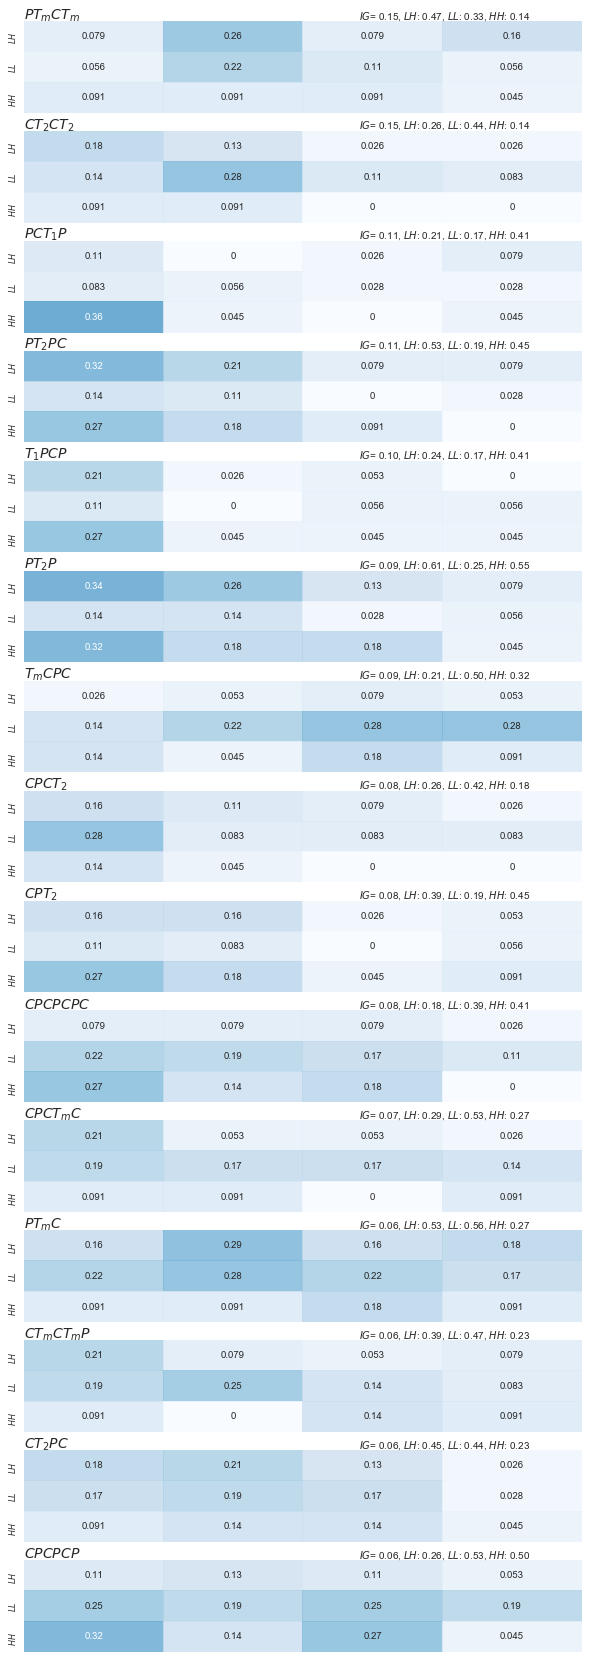

In [79]:
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*tops_group)[0]
fig, axes = plt.subplots(len(tops_group),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in sequence_counts_group.iteritems() if seq in all_seqs])
for i,(seq,ig) in enumerate(tops_group):
    ax = axes[i]
    data = sequence_counts_both[seq]
    lh,ll,hh = np.ndarray.tolist(sequence_counts_group[seq].T)[0]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,-0.07, seq, fontsize=14)
    ax.text(2.4,-0.07, "$IG$= {:.2f}, $LH$: {:.2f}, $LL$: {:.2f}, $HH$: {:.2f}".format(ig,lh,ll,hh), fontsize=10)
    
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=True) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,30)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ylabels = ['$LH$','$LL$','$HH$']
    ax.set_yticklabels(ylabels)
    ax.set_xticklabels(['','','',''])

In [31]:
(sequence_counts_both['CPCTs'].T*group_sizes).T

array([[ 6.,  4.,  3.,  1.],
       [10.,  3.,  3.,  3.],
       [ 3.,  1.,  0.,  0.]])

In [33]:
groups = 'LH LL HH'.split()
times = 't1 t2 t3 t4'.split()
seqdict = {}
for seq in tops_both:
    seqdict[seq[0]] = {}
    for i, group in enumerate(groups):
        seqdict[seq[0]][group] = {}
        for j, time in enumerate(times):
            seqdict[seq[0]][group][time] = (sequence_counts_both[seq[0]].T*group_sizes).T[i][j]

In [64]:
test = pd.DataFrame.from_dict({(i,j): seqdict[i][j] 
                           for i in seqdict.keys() 
                           for j in seqdict[i].keys()},
                       orient='index')
test.index.names = ['seq','group']
test = test.reset_index(level=[0,1])
# print test.head()
test = pd.melt(test, id_vars = ['seq','group'], var_name = 'time', value_name = 'counts')
test.to_csv('sequence_time_counts.csv', sep=',', index=False)

In [80]:
table = [['SEQ','IG','LH','LL','HH','t1','t2','t3','t4']]
tops_both.sort(key=lambda x: -x[1])
for seq,ig in tops_both:
#     print seq, round(ig,3), np.ndarray.tolist(sequence_counts_both[seq].T*group_sizes)[0]
    row = [seq,str(round(ig,2))] + [int(x*100) for x in np.sum(sequence_counts_both[seq], axis=1)] + [int(x*100) for x in np.sum((sequence_counts_both[seq].T*group_sizes).T, axis=0)/sum(group_sizes)]
    table.append(row)
print tabulate(table)

-------  ----  --  --  ---  --  --  --  --
SEQ      IG    LH  LL  HH   t1  t2  t3  t4
TbCP     1.11  47  33  36   31  4   1   3
PTb      0.99  52  41  63   39  6   3   2
PCTbP    0.87  21  19  45   15  3   2   5
CTbPC    0.73  42  47  59   31  2   10  4
CTbP     0.71  52  63  81   42  5   10  5
TbPCP    0.7   28  22  40   18  2   5   3
TbPC     0.57  65  58  72   40  6   11  6
PCTsP    0.55  63  33  54   20  17  11  0
CTcPTcP  0.54  44  41  31   8   20  10  1
CTsCTs   0.53  36  61  18   14  17  5   4
CPCTs    0.51  36  52  18   19  8   6   4
PTsPC    0.51  68  27  54   23  16  5   4
TbP      0.47  73  69  100  46  10  12  8
CTbC     0.42  84  75  45   39  12  7   12
CPTs     0.4   39  24  59   16  13  2   6
-------  ----  --  --  ---  --  --  --  --


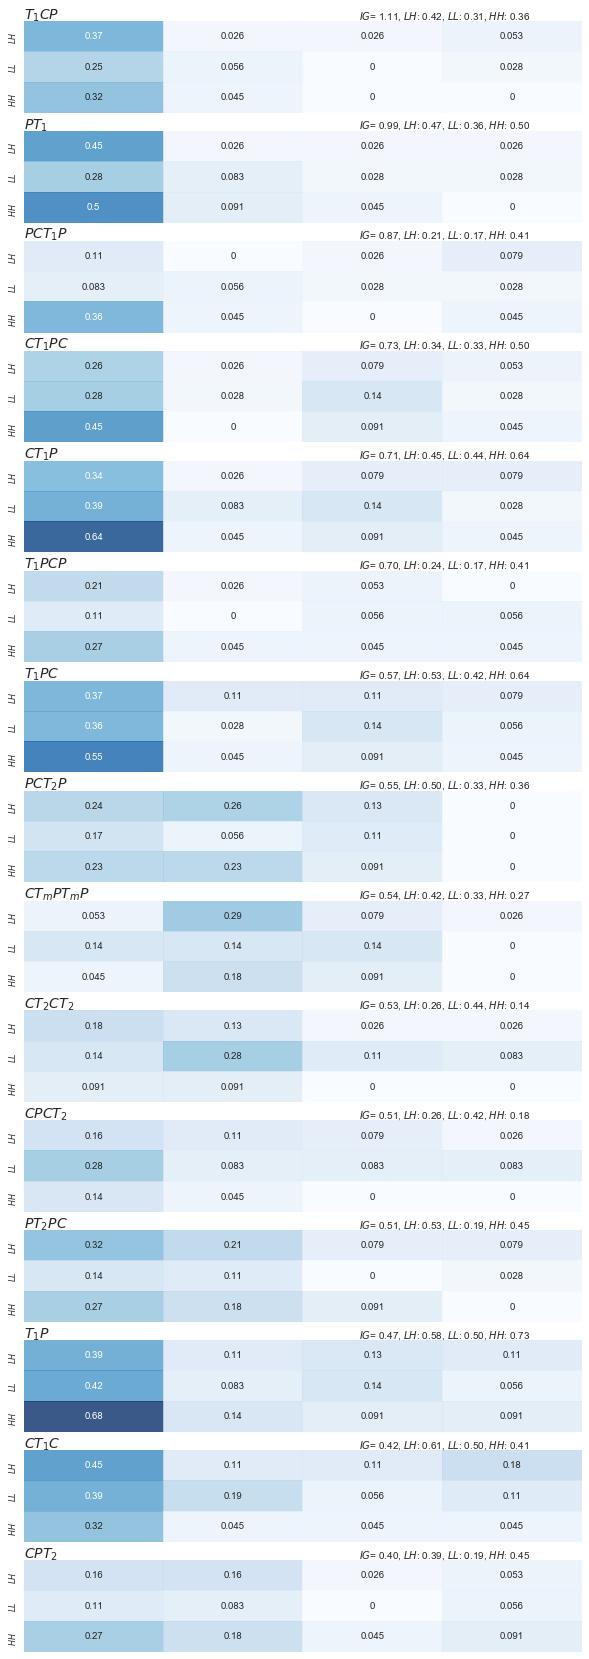

In [81]:
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*tops_both)[0]
fig, axes = plt.subplots(len(tops_both),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in sequence_counts_both.iteritems() if seq in all_seqs])
for i,(seq,ig) in enumerate(tops_both):
    ax = axes[i]
    data = sequence_counts_both[seq]
    lh,ll,hh = np.ndarray.tolist(sequence_counts_group[seq].T)[0]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,-0.07, seq, fontsize=14)
    ax.text(2.4,-0.07, "$IG$= {:.2f}, $LH$: {:.2f}, $LL$: {:.2f}, $HH$: {:.2f}".format(ig,lh,ll,hh), fontsize=10)
    
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=True) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,30)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ylabels = ['$LH$','$LL$','$HH$']
    ax.set_yticklabels(ylabels)
    ax.set_xticklabels(['','','',''])

In [20]:
table = [['SEQ','IG','time bin','LH','LL','HH','chi^2','p-val', 'LH-res', "LL-res", 'HH-res']]
for seq,ig in tops_both:
    for i in range(BINS):
        lh,ll,hh = (sequence_counts_both[seq].T*group_sizes)[i]
        if lh == ll == hh == 0:
            lh = ll = hh = 0.5
        tb = [[lh, group_sizes[0]-lh], [ll, group_sizes[1]-ll], [hh, group_sizes[2]-hh]]
        chi2, p, dof, ex = stats.chi2_contingency(tb, correction=True)
        if p < 0.1:
            res = (tb - ex)/np.sqrt(ex)
            cmarg = np.array(tb).sum(axis=0)
            rmarg = np.array(tb).sum(axis=1)
            n = np.array(tb).sum()
            res_adj = res
            res_adj[:,0] = res_adj[:,0]/np.sqrt(1-rmarg/n)/np.sqrt(1-cmarg[0]/n)
            seqt = seq.replace('Ts','T2').replace('Tb','T1').replace('Tc','Tm')
            row = [seqt, str(round(ig,2))] + [i] + [int(x*100) for x in list(np.ndarray.tolist(sequence_counts_both[seq].T)[i])] + [round(chi2, 3), round(p, 3)] + [round(r,2) for r in res_adj[:,0]]
            table.append(row)
print tabulate(table)

-----  ----  --------  --  --  --  -----  -----  ------  ------  ------
SEQ    IG    time bin  LH  LL  HH  chi^2  p-val  LH-res  LL-res  HH-res
T1P    0.47  0         39  41  68  5.239  0.073  -1.18   -0.79   2.28
PCT2P  0.55  1         26  5   22  5.961  0.051  1.79    -2.42   0.7
CT1P   0.71  0         34  38  63  5.274  0.072  -1.36   -0.59   2.26
PCT1P  0.87  0         10  8   36  9.378  0.009  -1.11   -1.52   3.05
-----  ----  --------  --  --  --  -----  -----  ------  ------  ------


In [154]:
table = [['SEQ','IG','t1','t2','t3', 't4']]
tops_time.sort(key=lambda x: -x[1])
for seq,ig in tops_time:
#     print seq, round(ig,3), np.ndarray.tolist(sequence_counts_time[seq].T*group_sizes)[0]
    row = [seq,str(round(ig,2))] + [int(x*100) for x in np.sum((sequence_counts_both[seq].T*group_sizes).T, axis=0)/sum(group_sizes)]
    table.append(row)
print tabulate(table)

-------  ----  --  --  --  --
SEQ      IG    t1  t2  t3  t4
TbCP     1.01  31  4   1   3
PTb      0.92  39  6   3   2
CTbPC    0.67  31  2   10  4
CTbP     0.64  42  5   10  5
PCTbP    0.53  15  3   2   5
TbPC     0.53  40  6   11  6
TbPCP    0.52  18  2   5   3
PCTsP    0.46  20  17  11  0
TbP      0.43  46  10  12  8
CTcPTcP  0.41  8   20  10  1
TbC      0.35  52  12  13  13
PTsPC    0.34  23  16  5   4
CTbC     0.34  39  12  7   12
CTsPTs   0.33  25  18  9   2
CPCTs    0.29  19  8   6   4
-------  ----  --  --  --  --


## Let's run the sequence mining this time ignoring first time bin

We ignore the first time bin in the selection of non-rare sequences AND in our calculation of information gain

In [82]:
BINS = 4
axis = None
sequence_counts_both_ignore_first = get_sequence_use_by_timebin(df,students,family_category,
                                  BINS,attribute,level1,level2,
                                  shortest_seq_length,longest_seq_length,CUT_OFF,
                                    level3='HH',ignore=['I'],ignore_first_time_bin=True)
sequence_counts_both_ignore_first = {s:counts/group_sizes[:,None] for s,counts in sequence_counts_both_ignore_first.iteritems()}
tops_both_ignore_first = get_top_seqs(rank_sequences(sequence_counts_both_ignore_first,BINS,axis,ignore_first_time_bin=True),15)

axis = 0
tops_time_ignore_first = get_top_seqs(rank_sequences(sequence_counts_both_ignore_first,BINS,axis,ignore_first_time_bin=True),15)

Getting sequence use over 4 time bins for 96 students split by three groups. 
    Keeping only sequences used once by at least 40% of students 
    in each group and overall.


In [83]:
table = [['SEQ','IG','t1','t2','t3', 't4']]
tops_time_ignore_first.sort(key=lambda x: -x[1])
for seq,ig in tops_time_ignore_first:
#     print seq, round(ig,3), np.ndarray.tolist(sequence_counts_time[seq].T*group_sizes)[0]
    seqt = seq.replace('Ts','T2').replace('Tb','T1').replace('Tc','Tm')
    row = [seqt,str(round(ig,2))] + [int(x*100) for x in np.sum((sequence_counts_both_ignore_first[seq].T*group_sizes).T, axis=0)/sum(group_sizes)]
    table.append(row)
print tabulate(table)

-------  ----  --  --  --  --
SEQ      IG    t1  t2  t3  t4
CT2P     0.24  35  30  19  5
TmPTmPC  0.23  6   18  16  4
CTmPTm   0.2   14  27  17  6
TmPTmP   0.17  8   19  18  6
PCT2     0.16  38  29  17  9
T2PC     0.15  38  30  19  9
PT2P     0.15  26  19  10  6
PCTmCTm  0.12  16  19  14  6
PTmCTm   0.1   7   20  9   9
T2P      0.1   45  32  27  12
PT2      0.1   36  29  17  10
CT2      0.1   50  44  29  17
PTmPC    0.09  9   20  26  10
TmPTm    0.09  13  33  26  13
T2C      0.09  32  35  22  15
-------  ----  --  --  --  --


In [84]:
print "New seqs from dropping first time bin:\n\t",set(zip(*tops_time_ignore_first)[0]) - set(zip(*tops_time)[0])

New seqs from dropping first time bin:
	set(['PCTs', 'TcPTcPC', 'CTs', 'PTsP', 'TsC', 'PCTcCTc', 'TsPC', 'PTcPC', 'CTcPTc', 'CTsP', 'TcPTcP', 'PTcCTc', 'PTs', 'TsP', 'TcPTc'])


In [85]:
table = [['SEQ','IG','LH','LL','HH','t1','t2','t3','t4']]
tops_both_ignore_first.sort(key=lambda x: -x[1])
for seq,ig in tops_both_ignore_first:
#     print seq, round(ig,3), np.ndarray.tolist(sequence_counts_both[seq].T*group_sizes)[0]
#     print seq,sequence_counts_both_ignore_first[seq]
    seqt = seq.replace('Ts','T2').replace('Tb','T1').replace('Tc','Tm')
    row = [seqt,str(round(ig,2))] + [int(x*100) for x in np.sum(sequence_counts_group[seq], axis=1)] + [int(x*100) for x in np.sum((sequence_counts_both_ignore_first[seq].T*group_sizes).T, axis=0)/sum(group_sizes)]
    table.append(row)
print tabulate(table)

--------  ----  --  --  --  --  --  --  --
SEQ       IG    LH  LL  HH  t1  t2  t3  t4
CPCTmC    0.37  28  52  27  17  10  8   8
TmPTmPC   0.34  42  36  31  6   18  16  4
TmCPC     0.31  21  50  31  9   11  17  14
TmPTmP    0.3   50  41  31  8   19  18  6
PCTmCTm   0.28  31  55  40  16  19  14  6
CT2P      0.28  57  58  50  35  30  19  5
PCT2      0.27  65  63  45  38  29  17  9
CTmPTm    0.27  52  52  36  14  27  17  6
PT2P      0.27  60  25  54  26  19  10  6
CT2C      0.26  55  58  31  29  22  16  13
TmCTmP    0.25  52  52  31  18  28  15  11
TmCTmCTm  0.23  23  44  27  7   10  15  11
PTmCTm    0.22  47  33  13  7   20  9   9
CTmCTm    0.22  50  66  50  23  28  26  17
CTmCTmC   0.21  28  47  40  9   16  22  11
--------  ----  --  --  --  --  --  --  --


In [86]:
print "New seqs from dropping first time bin:\n\t",set(zip(*tops_both_ignore_first)[0]) - set(zip(*tops_both)[0])

New seqs from dropping first time bin:
	set(['CPCTcC', 'TcPTcPC', 'PTsP', 'CTsC', 'CTcCTcC', 'TcCTcP', 'PCTcCTc', 'PCTs', 'CTsP', 'TcCPC', 'CTcPTc', 'TcPTcP', 'TcCTcCTc', 'CTcCTc', 'PTcCTc'])


In [87]:
table = [['SEQ','IG','time bin','LH','LL','HH','chi^2','p-val', 'LH-res', "LL-res", 'HH-res']]
for seq,ig in tops_both_ignore_first:
    for i in range(BINS):
        lh,ll,hh = (sequence_counts_both_ignore_first[seq].T*group_sizes)[i]
        if lh == ll == hh == 0:
            lh = ll = hh = 0.5
        tb = [[lh, group_sizes[0]-lh], [ll, group_sizes[1]-ll], [hh, group_sizes[2]-hh]]
        chi2, p, dof, ex = stats.chi2_contingency(tb, correction=True)
        if p < 0.06:
            res = (tb - ex)/np.sqrt(ex)
            cmarg = np.array(tb).sum(axis=0)
            rmarg = np.array(tb).sum(axis=1)
            n = np.array(tb).sum()
            res_adj = res
            res_adj[:,0] = res_adj[:,0]/np.sqrt(1-rmarg/n)/np.sqrt(1-cmarg[0]/n)
            seqt = seq.replace('Ts','T2').replace('Tb','T1').replace('Tc','Tm')
            row = [seqt, str(round(ig,2))] + [i] + [int(x*100) for x in list(np.ndarray.tolist(sequence_counts_both_ignore_first[seq].T)[i])] + [round(chi2, 3), round(p, 3)] + [round(r,2) for r in res_adj[:,0]]
            table.append(row)
print tabulate(table)

--------  ----  --------  --  --  --  ------  -----  ------  ------  ------
SEQ       IG    time bin  LH  LL  HH  chi^2   p-val  LH-res  LL-res  HH-res
CPCTmC    0.37  2         5   16  0   5.742   0.057  -0.88   2.29    -1.61
TmCPC     0.31  1         5   22  4   6.585   0.037  -1.54   2.56    -1.16
TmCPC     0.31  3         5   27  9   8.214   0.016  -2.09   2.84    -0.83
PCTmCTm   0.28  1         10  33  13  6.739   0.034  -1.84   2.58    -0.83
CT2C      0.26  1         18  36  9   6.363   0.042  -0.85   2.38    -1.76
CT2C      0.26  2         13  27  4   5.864   0.053  -0.75   2.26    -1.74
TmCTmP    0.25  1         36  33  4   7.962   0.019  1.54    0.88    -2.8
TmCTmCTm  0.23  1         2   22  4   8.657   0.013  -2.02   2.93    -1.03
CTmCTm    0.22  1         13  47  22  11.023  0.004  -2.64   3.22    -0.64
CTmCTm    0.22  2         7   41  31  11.442  0.003  -3.28   2.7     0.7
CTmCTmC   0.21  2         7   36  27  8.638   0.013  -2.83   2.38    0.55
--------  ----  --------  -

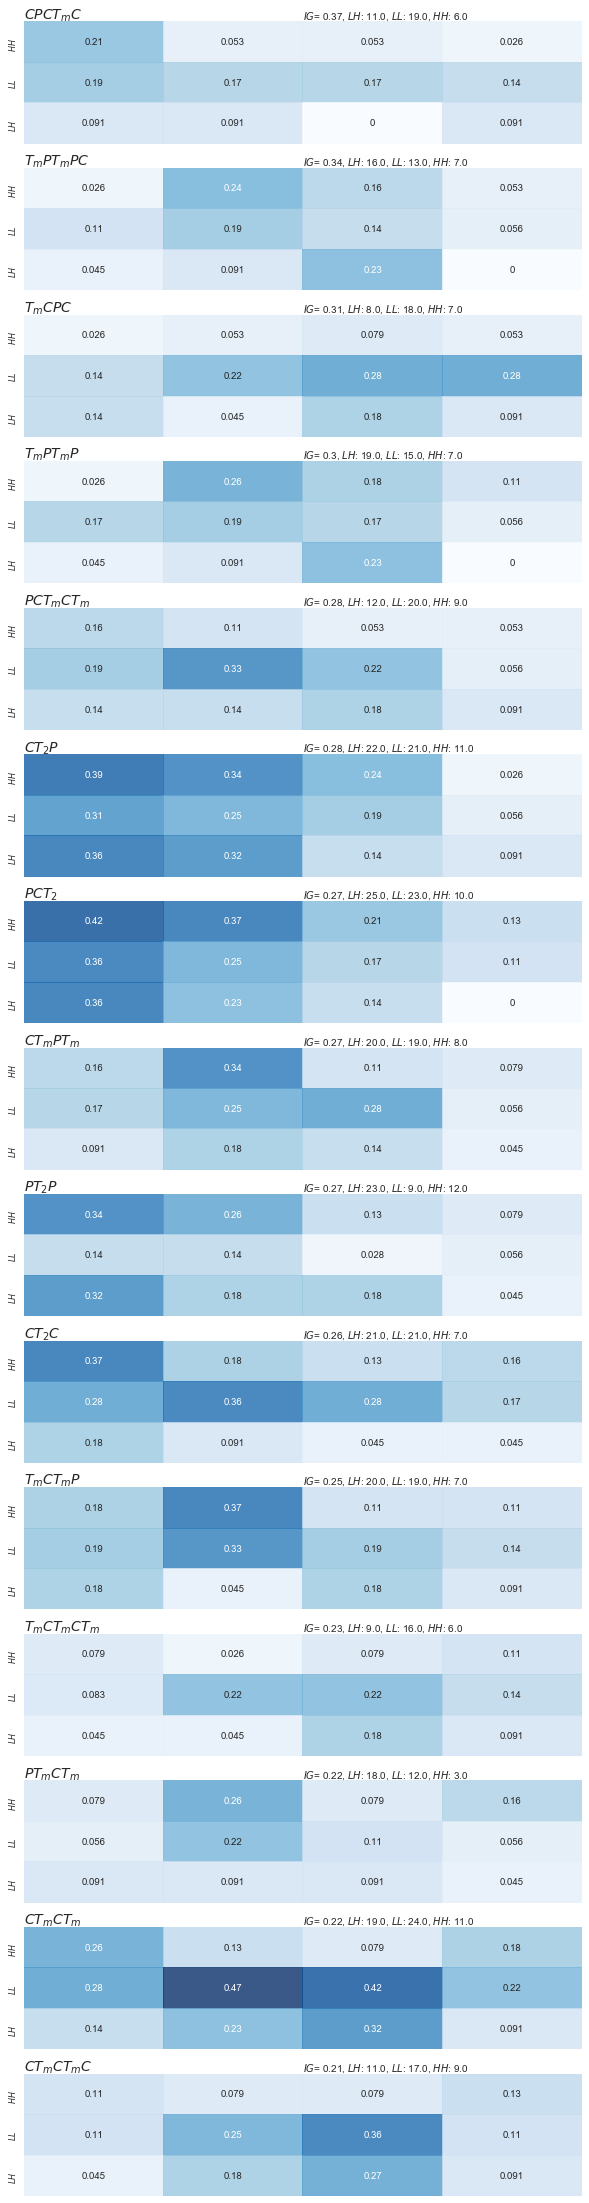

In [88]:
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*tops_both_ignore_first)[0]
fig, axes = plt.subplots(len(tops_both_ignore_first),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in sequence_counts_both_ignore_first.iteritems() if seq in all_seqs])
for i,(seq,ig) in enumerate(tops_both_ignore_first):
    ax = axes[i]
    data = sequence_counts_both_ignore_first[seq]
    hl,ll,hh = np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,-0.07, seq, fontsize=14)
    ax.text(2.0,-0.07, "$IG$= {0}, $LH$: {1}, $LL$: {2}, $HH$: {3}".format(str(round(ig,2)),hl,ll,hh), fontsize=10)
    
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=True) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,40)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ylabels = ['$HH$','$LL$','$LH$']
    ax.set_yticklabels(ylabels)
    ax.set_xticklabels(['','','',''])
        
    i += 1

## Other analysis
### Specific sequence look-up

In [162]:
seq = 'Tc'
table = [['SEQ','IG','LH','LL','HH','chi^2','p-val', 'LH-res', "LL-res", 'HH-res']]
lh,ll,hh = (sequence_counts_group[seq].T*group_sizes)[0]
tb = [[lh, group_sizes[0]-lh], [ll, group_sizes[1]-ll], [hh, group_sizes[2]-hh]]
chi2, p, dof, ex = stats.chi2_contingency(tb, correction=False)
res = (tb - ex)/np.sqrt(ex)
cmarg = np.array(tb).sum(axis=0)
rmarg = np.array(tb).sum(axis=1)
res_adj = res
res_adj[:,0] = res_adj[:,0]/np.sqrt(1-rmarg/n)/np.sqrt(1-cmarg[0]/n)
n = np.array(tb).sum()
row = [seq, str(round(ig,2))] + [int(x*100) for x in list(np.ndarray.tolist(sequence_counts_group[seq].T)[0])] + [round(chi2, 3), round(p, 3)] + [round(r,2) for r in res_adj[:,0]]
table.append(row)
print tabulate(table)

---  ----  --  --  --  -----  -----  ------  ------  ------
SEQ  IG    LH  LL  HH  chi^2  p-val  LH-res  LL-res  HH-res
Tc   0.21  92  97  81  4.258  0.119  0.13    1.53    -1.9
---  ----  --  --  --  -----  -----  ------  ------  ------


### Single actions:

In [163]:
#get sequence info for single action sequences and IG
actions = 'C P Tb Ts Tc'.split()

BINS = 1
axis = 1
single_action_counts_group = {action:sequence_counts_group[action] for action in actions}
tops_group_single_action = get_top_seqs(rank_sequences(single_action_counts_group,BINS,axis),len(actions))
tops_group_single_action.sort(key=lambda x: -x[1])
print tops_group_single_action

BINS = 4
axis = None
single_action_counts_both = {action:sequence_counts_both[action] for action in actions}
tops_both_single_action = get_top_seqs(rank_sequences(single_action_counts_both,BINS,axis),len(actions))
tops_both_single_action.sort(key=lambda x: -x[1])
print tops_both_single_action

[('Tb', 0.01491554141525242), ('Ts', 0.010839753160094556), ('Tc', 0.003660904508506757), ('P', 0.0), ('C', 0.0)]
[('Tb', 0.2462732552232918), ('Ts', 0.09113352646830775), ('Tc', 0.030955587180219624), ('C', 0.00176194196552526), ('P', 0.0014845150129207951)]


In [199]:
table = [['SEQ','IG','LH','LL','HH','chi^2','p-val', 'LH-res', "LL-res", 'HH-res']]
for seq,ig in tops_group_single_action:
    lh,ll,hh = (single_action_counts_group[seq].T*group_sizes)[0]
    if lh == ll == hh == 0:
            lh = ll = hh = 0.5
    elif (lh == group_sizes[0]) & (ll == group_sizes[1]) & (hh == group_sizes[2]):
        lh = group_sizes[0] - 0.5
        ll = group_sizes[1] - 0.5
        hh = group_sizes[2] - 0.5
    tb = [[lh, group_sizes[0]-lh], [ll, group_sizes[1]-ll], [hh, group_sizes[2]-hh]]
    chi2, p, dof, ex = stats.chi2_contingency(tb, correction=True)
    res = (tb - ex)/np.sqrt(ex)
    cmarg = np.array(tb).sum(axis=0)
    rmarg = np.array(tb).sum(axis=1)
    n = np.array(tb).sum()
    res_adj = res
    res_adj[:,0] = res_adj[:,0]/np.sqrt(1-rmarg/n)/np.sqrt(1-cmarg[0]/n)
    row = [seq, str(round(ig,2))] + [round(x,2) for x in list(np.ndarray.tolist(single_action_counts_group[seq].T)[0])] + [round(chi2, 3), round(p, 3)] + [round(r,2) for r in res_adj[:,0]]
    table.append(row)
print tabulate(table)
np.savetxt("single_action_group_chi2_data.csv", table, delimiter=",", fmt='%s')

---  ----  ----  ----  ----  -----  -----  ------  ------  ------
SEQ  IG    LH    LL    HH    chi^2  p-val  LH-res  LL-res  HH-res
Tb   0.01  0.82  0.64  0.91  6.363  0.042  0.85    -2.38   1.76
Ts   0.01  0.87  0.67  0.68  4.721  0.094  2.17    -1.46   -0.84
Tc   0.0   0.92  0.97  0.82  4.258  0.119  0.13    1.53    -1.9
P    0.0   1.0   1.0   1.0   0.094  0.954  0.16    0.11    -0.31
C    0.0   1.0   1.0   1.0   0.094  0.954  0.16    0.11    -0.31
---  ----  ----  ----  ----  -----  -----  ------  ------  ------


In [200]:
table = [['SEQ','IG','time bin','LH','LL','HH','chi^2','p-val', 'LH-res', "LL-res", 'HH-res']]
for seq,ig in tops_both_single_action:
    for i in range(BINS):
        lh,ll,hh = (single_action_counts_both[seq].T*group_sizes)[i]
        if lh == ll == hh == 0:
            lh = ll = hh = 0.5
        elif (lh == group_sizes[0]) & (ll == group_sizes[1]) & (hh == group_sizes[2]):
            lh = group_sizes[0] - 0.5
            ll = group_sizes[1] - 0.5
            hh = group_sizes[2] - 0.5
        tb = [[lh, group_sizes[0]-lh], [ll, group_sizes[1]-ll], [hh, group_sizes[2]-hh]]
        chi2, p, dof, ex = stats.chi2_contingency(tb, correction=True)
        if p < 0.1:
            res = (tb - ex)/np.sqrt(ex)
            cmarg = np.array(tb).sum(axis=0)
            rmarg = np.array(tb).sum(axis=1)
            n = np.array(tb).sum()
            res_adj = res
            res_adj[:,0] = res_adj[:,0]/np.sqrt(1-rmarg/n)/np.sqrt(1-cmarg[0]/n)
            row = [seq, str(round(ig,2))] + [i] + [round(x,2) for x in list(np.ndarray.tolist(single_action_counts_both[seq].T)[i])] + [round(chi2, 3), round(p, 3)] + [round(r,2) for r in res_adj[:,0]]
            table.append(row)
print tabulate(table)
np.savetxt("single_action_both_chi2_data.csv", table, delimiter=",", fmt='%s')

---  ----  --------  ----  ----  ----  -----  -----  ------  ------  ------
SEQ  IG    time bin  LH    LL    HH    chi^2  p-val  LH-res  LL-res  HH-res
Tb   0.25  0         0.68  0.53  0.82  5.323  0.07   0.47    -2.05   1.82
Tc   0.03  1         0.68  0.78  0.45  6.507  0.039  0.3     1.79    -2.4
---  ----  --------  ----  ----  ----  -----  -----  ------  ------  ------


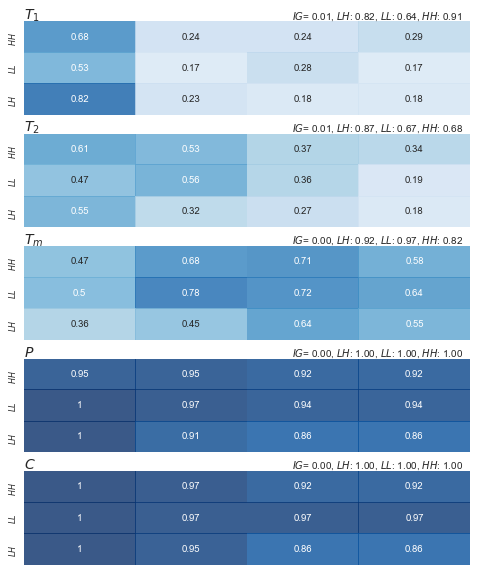

In [194]:
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*tops_group_single_action)[0]
fig, axes = plt.subplots(len(tops_group_single_action),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in single_action_counts_both.iteritems() if seq in all_seqs])
for i,(seq,ig) in enumerate(tops_group_single_action):
    ax = axes[i]
    data = single_action_counts_both[seq]
    hl,ll,hh = np.ndarray.tolist(single_action_counts_group[seq].T)[0]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,-0.07, seq, fontsize=14)
    ax.text(2.4,-0.07, "$IG$= {:.2f}, $LH$: {:.2f}, $LL$: {:.2f}, $HH$: {:.2f}".format(ig,hl,ll,hh), fontsize=10)
    
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=True) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(8,10)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ylabels = ['$HH$','$LL$','$LH$']
    ax.set_yticklabels(ylabels)
    ax.set_xticklabels(['','','',''])
        
    i += 1

### Let's analyze the building blocks

In [15]:
blocks_LH, time_coords_LH =  get_blocks_withTime_new(df,get_students('three groups','LH'),"Family",start=False,ignore=['I'], as_list=True)
blocks_LL, time_coords_LL =  get_blocks_withTime_new(df,get_students('three groups','LL'),"Family",start=False,ignore=['I'], as_list=True)
blocks_HH, time_coords_HH =  get_blocks_withTime_new(df,get_students('three groups','HH'),"Family",start=False,ignore=['I'], as_list=True)

In [16]:
def get_frequencies(seq_of_interest,blocks1,blocks2,blocks3,normalize_by='length'):
    def coo(seq, seq_of_interest):
        return float(occurrences(''.join(seq),seq_of_interest))
    
    if normalize_by == None:
        # count number of occurrences of "seq_of_interest" in a student's seq
        freq1 = {student : coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()}
        freq3 = {student : coo(seq, seq_of_interest) for student,seq in blocks3.iteritems()}
    elif normalize_by == 'length':
        len_seqi = len(''.join([c for c in seq_of_interest if c.isupper()]))
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the length of seq
        print [(student, len(seq)) for student,seq in blocks1.iteritems()]
        freq1 = {student : coo(seq, seq_of_interest)/(len(seq)-len_seqi+1) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/(len(seq)-len_seqi+1) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks2.iteritems()}
        freq3 = {student : coo(seq, seq_of_interest)/(len(seq)-len_seqi+1) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks3.iteritems()}
    else:
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the number of occurrences of the seq "normalize_by"
        freq1 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks2.iteritems()}
        freq3 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks3.iteritems()}
    return freq1.values(),freq2.values(),freq3.values()

def occurrences(string, sub):
    count = start = 0
    while True:
        start = string.find(sub, start) + 1
        if start > 0:
            count+=1
        else:
            return count
        
def make_hist_continuous(seq_of_interest,freq_LH,freq_LL,freq_HH):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    alldata = np.concatenate((freq_LH, freq_LL, freq_HH), axis=0)
    binsize = max(alldata)/10.
    bins = np.arange(0,max(alldata)+binsize,binsize)
#     plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
#     plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
#     plt.hist(freq_HH,color = 'g',alpha = 0.4,bins = bins)
    plt.hist([freq_LH,freq_LL,freq_HH], bins=bins, stacked=True)
    plt.title("Use of the sequence ''{0}'' by LH (red) and LL (blue) and HH (purple)".format(seq_of_interest))
    return plt

In [17]:
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
import warnings


def kw_dunn(groups, to_compare=None, alpha=0.05, method='bonf'):
    """

    Kruskal-Wallis 1-way ANOVA with Dunn's multiple comparison test

    Arguments:
    ---------------
    groups: sequence
        arrays corresponding to k mutually independent samples from
        continuous populations

    to_compare: sequence
        tuples specifying the indices of pairs of groups to compare, e.g.
        [(0, 1), (0, 2)] would compare group 0 with 1 & 2. by default, all
        possible pairwise comparisons between groups are performed.

    alpha: float
        family-wise error rate used for correcting for multiple comparisons
        (see statsmodels.stats.multitest.multipletests for details)

    method: string
        method used to adjust p-values to account for multiple corrections (see
        statsmodels.stats.multitest.multipletests for options)

    Returns:
    ---------------
    H: float
        Kruskal-Wallis H-statistic

    p_omnibus: float
        p-value corresponding to the global null hypothesis that the medians of
        the groups are all equal

    Z_pairs: float array
        Z-scores computed for the absolute difference in mean ranks for each
        pairwise comparison

    p_corrected: float array
        corrected p-values for each pairwise comparison, corresponding to the
        null hypothesis that the pair of groups has equal medians. note that
        these are only meaningful if the global null hypothesis is rejected.

    reject: bool array
        True for pairs where the null hypothesis can be rejected for the given
        alpha

    Reference:
    ---------------
    Gibbons, J. D., & Chakraborti, S. (2011). Nonparametric Statistical
    Inference (5th ed., pp. 353-357). Boca Raton, FL: Chapman & Hall.

    """

    # omnibus test (K-W ANOVA)
    # -------------------------------------------------------------------------

    groups = [np.array(gg) for gg in groups]

    k = len(groups)

    n = np.array([len(gg) for gg in groups])
    if np.any(n < 5):
        warnings.warn("Sample sizes < 5 are not recommended (K-W test assumes "
                      "a chi square distribution)")

    allgroups = np.concatenate(groups)
    N = len(allgroups)
    ranked = stats.rankdata(allgroups)

    # correction factor for ties
    T = stats.tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in kruskal')

    # sum of ranks for each group
    j = np.insert(np.cumsum(n), 0, 0)
    R = np.empty(k, dtype=np.float)
    for ii in range(k):
        R[ii] = ranked[j[ii]:j[ii + 1]].sum()

    # the Kruskal-Wallis H-statistic
    H = (12. / (N * (N + 1.))) * ((R ** 2.) / n).sum() - 3 * (N + 1)

    # apply correction factor for ties
    H /= T

    df_omnibus = k - 1
    p_omnibus = stats.distributions.chi2.sf(H, df_omnibus)

    # multiple comparisons
    # -------------------------------------------------------------------------

    # by default we compare every possible pair of groups
    if to_compare is None:
        to_compare = tuple(combinations(range(k), 2))

    ncomp = len(to_compare)

    Z_pairs = np.empty(ncomp, dtype=np.float)
    p_uncorrected = np.empty(ncomp, dtype=np.float)
    Rmean = R / n

    for pp, (ii, jj) in enumerate(to_compare):
        
        # standardized score
        ts3_ts = list(np.unique(allgroups, return_counts=True)[1])
        E_ts3_ts = sum([x**3 - x for x in ts3_ts if x>1])

        if sum([x>1 for x in ts3_ts]) > 0:
            warnings.warn("We see ties.")

            yi = np.abs(Rmean[ii] - Rmean[jj])
            theta10 = (N * (N + 1)) / 12
            theta11 =  E_ts3_ts / ( 12* (N - 1) )
            theta2 = (1. / n[ii] + 1. / n[jj])
            theta = np.sqrt( (theta10 - theta11) * theta2 )
            Zij = yi / theta
        else:
            Zij = (np.abs(Rmean[ii] - Rmean[jj]) /
                   np.sqrt((1. / 12.) * N * (N + 1) * (1. / n[ii] + 1. / n[jj])))
        
#         # standardized score
#         Zij = (np.abs(Rmean[ii] - Rmean[jj]) /
#                np.sqrt((1. / 12.) * N * (N + 1) * (1. / n[ii] + 1. / n[jj])))
        Z_pairs[pp] = Zij

    # corresponding p-values obtained from upper quantiles of the standard
    # normal distribution
    p_uncorrected = stats.norm.sf(Z_pairs) * 2.

    # correction for multiple comparisons
    reject, p_corrected, alphac_sidak, alphac_bonf = multipletests(
        p_uncorrected, method=method
    )

    return H, p_omnibus, Z_pairs, p_corrected, reject

Comparing the median frequency usage of sequence CTcPTcP normalized by None
Kruskal omnibus test: H statistic = 1.66666666667, p<0.434598208507
Dunn's pairwise post hoc test with Bonferonni:
LH vs LL: Z score = 1.02062072616, p<0.922302497782
LH vs HH: Z score = 1.02062072616, p<0.922302497782
LL vs HH: Z score = 0.0, p<1.0
[0.0, 1.0, 2.0] [0.0] [0.0]


/Users/jonathanma/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:69: UserWarning: Sample sizes < 5 are not recommended (K-W test assumes a chi square distribution)
/Users/jonathanma/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:116: UserWarning: We see ties.


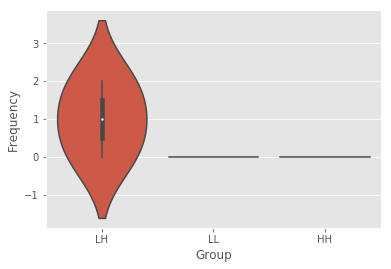

In [38]:
seq = 'CTcPTcP'
norm = None
# norm = 'length'
# norm = 'Ts'
freq_LH,freq_LL,freq_HH = get_frequencies(seq,blocks_LH,blocks_LL,blocks_HH,normalize_by=None)
freqname = 'Frequency'
groupname = 'Group'

df0 = pd.DataFrame(freq_LH, columns=[freqname])
df0[groupname] = 'LH'
df1 = pd.DataFrame(freq_LL, columns=[freqname])
df1[groupname] = 'LL'
df2 = pd.DataFrame(freq_HH, columns=[freqname])
df2[groupname] = 'HH'
df_all = df0.append(df1).append(df2).reset_index()
# df_all.boxplot('freq',by='group')


ax = sns.violinplot(x=groupname, y=freqname, data=df_all)
# ax = sns.boxplot(x=groupname, y=freqname, data=df_all)
# ax = sns.swarmplot(x=groupname, y=freqname, data=df_all, edgecolor="black", linewidth=.9)

# F, p = stats.kruskal(freq_LH,freq_LL,freq_HH)
# print F, p
print "Comparing the median frequency usage of sequence {0} normalized by {1}".format(seq, norm)
H, p_omnibus, Z_pairs, p_corrected, reject = kw_dunn([freq_LH,freq_LL,freq_HH])
print "Kruskal omnibus test: H statistic = {0}, p<{1}".format(H, p_omnibus)
print "Dunn's pairwise post hoc test with Bonferonni:"
print "LH vs LL: Z score = {0}, p<{1}".format(Z_pairs[0], p_corrected[0])
print "LH vs HH: Z score = {0}, p<{1}".format(Z_pairs[1], p_corrected[1])
print "LL vs HH: Z score = {0}, p<{1}".format(Z_pairs[2], p_corrected[2])

# print stats.f_oneway(freq_LH,freq_LL,freq_HH)
# print pairwise_tukeyhsd(Data, Group)
print freq_LH,freq_LL,freq_HH

### The following exports dataframe for group x time analysis in R

In [37]:
student1 = {1075123, 3591123, 8775127}
student2 = {3932129}
student3 = {4936123}

blocks_LH, time_coords_LH =  get_blocks_withTime_new(df,student1,"Family",start=False,ignore=['I'], as_list=True)
blocks_LL, time_coords_LL =  get_blocks_withTime_new(df,student2,"Family",start=False,ignore=['I'], as_list=True)
blocks_HH, time_coords_HH =  get_blocks_withTime_new(df,student3,"Family",start=False,ignore=['I'], as_list=True)

freq_LH,freq_LL,freq_HH = get_frequencies('Ts',blocks_LH,blocks_LL,blocks_HH,normalize_by=None)

print freq_LH,freq_LL,freq_HH

[8.0, 4.0, 4.0] [6.0] [7.0]


In [35]:
students = list(set(df_scores['student']) - set(df_scores[df_scores['three groups']=='HL']['student']))

blocks, time_coords =  get_blocks_withTime_new(df, students, "Family",
                                                     start=False, ignore=['I', 'To'], as_list=True)

frequencies_by_bin = get_frequencies_by_bin(blocks, students, time_coords, 4, shortest = 1, longest = 4)

interestingSequences = [seqIGtuple[0] for seqIGtuple in tops_group]


In [36]:
# interestingSequences = ['C','P','Ts','Tb','Tc']
timebins = range(4)
students = frequencies_by_bin.keys()

data = {}
for student in students:
    data[student] = {}
    for seq in interestingSequences:
        data[student][seq] = {}
        for timebin in timebins:
            if seq in frequencies_by_bin[student][timebin]:
                data[student][seq][timebin] = 1
            else:
                data[student][seq][timebin] = 0

grptimedf = pd.DataFrame({(student, seq): data[student][seq]
                           for student in students
                           for seq in interestingSequences
                           })

grptimedf['timebin'] = grptimedf.index
grptimedf = grptimedf.melt(id_vars = ['timebin'], var_name = ['sid','sequence'], value_name = 'use')
grptimedf['group'] = grptimedf['sid'].apply(lambda row: list(df_scores[df_scores['student']==row]['three groups'])[0])
grptimedf.to_csv('tops_group_groupXtime_sequences_2.csv', sep=',', index=False)


In [39]:
temp = grptimedf[grptimedf['sequence'] == 'CTcPTcP']
temp.groupby(['timebin', 'group']).sum().unstack()

timebin


In [30]:
sequence_counts_both['CPTs'].T*group_sizes

array([[6., 4., 6.],
       [6., 3., 4.],
       [1., 0., 1.],
       [2., 2., 2.]])